### This Notebook solves the stochastic growth model with CRRA utility and Markovian shocks using value function iteration and a discrete state space. Iterations performed with loops.

#### Translated from Eva Carceles-Poveda's MATLAB codes

In [1]:
# Importing packages
import numpy as np
import matplotlib.pyplot as plt
# The magic command below causes the resulting plots to be stored in the notebook document
# Only works in IPython Notebooks and not in regular Python files
%matplotlib inline 

# needed for compact printing of numpy arrays
# use precision to set the number of decimal digits to display
# use suppress=True to show values in full decimals instead of using scientific notation
np.set_printoptions(suppress=True,precision=4,linewidth=np.inf)

#### The functions markov_approx and markov_chain are copied below.

In [2]:
# markovapprox: approximates a continuous AR(1) process with a Markov chain
# Eva Carceles-Poveda's version. You can use this function, Floden's tauchen function, or Sargent's tauchen function.

from scipy.stats import norm
def markov_approx(rho, sigma, m, N):
    """ Syntax: [Tran,s,p,arho,asigma]=markovapprox(rho,sigma,m,N)
    
    This function approximates a first-order autoregressive process 
    with persistence rho and innovation standard deviation sigma with 
    an N state Markov chain; m determines the width of the discretized 
    state space, Tauchen uses m=3, with ymax=m*vary,ymin=-m*vary, where 
    ymax and ymin are the two boundary points, Tran is the transition 
    matrix of the Markov chain, s is the discretized state space, p is 
    the chain stationary distribution, arho is the theoretical first 
    order autoregression coefficient for the Markov chain, asigma is 
    the theoretical standard deviation for the Markov chain.
    
    Translated from Eva Carceles-Poveda 2003 MATLAB code
    """
    
    # Discretize the state space
    stvy = np.sqrt(sigma**2/(1-rho**2))   # standard deviation of y(t)
    ymax = m*stvy                         # upper boundary of state space
    ymin = -ymax                          # lower boundary of state space
    w = (ymax-ymin)/(N-1)                 # distance between points
    s = w * np.arange(ymin/w, ymax/w+1)   # the discretized state space        
    
    
    # Calculate the transition matrix
    Tran = np.zeros((N,N))
    for j in np.arange(0,N):
        for k in np.arange(1,N-1):
            Tran[j,k] = norm.cdf(s[k]-rho*s[j]+w/2,0,sigma) - norm.cdf(s[k]-rho*s[j]-w/2,0,sigma);
            
        Tran[j,0] = norm.cdf(s[0]-rho*s[j]+w/2,0,sigma);
        Tran[j,N-1] = 1 - norm.cdf(s[N-1]-rho*s[j]-w/2,0,sigma);
        
    # Check that Tran is well specified
    if not np.all(np.isclose(np.sum(Tran.T, axis=0), np.squeeze(np.ones((1,N))))):
        # find rows not adding up to one
        str = (np.absolute(np.sum(Tran.T, axis=0))-np.squeeze(np.ones((1,N)))<1e-14).nonzero()          
        print('error in transition matrix')
        print('rows', str[0],' do not sum to one')
    
    
    # Calculate the invariant distribution of Markov chain
    Trans = Tran.T
    p = (1/N)*np.ones((N,1)) # initial distribution of states
    test = 1;
    while test > 1e-8:
        p1 = np.matmul(Trans,p)
        test=np.max(np.abs(p1-p))
        p = p1
    
    
    meanm = np.matmul(s,p)            # mean of invariant distribution of chain
    varm = np.matmul((s-meanm)**2,p)  #variance of invariant distribution of chain  
    midaut1 = np.matmul((s-meanm)[:, np.newaxis],(s-meanm)[np.newaxis, :]) # cross product of deviation from mean of yt and yt-1                    
    probmat = np.matmul(p,np.ones((1,N)))     # each column is invariant distribution   
    midaut2 = Tran*probmat*midaut1 # product of the first two terms is joint distribution of (Yt-1,Yt)                                    
    autcov1 = np.sum(midaut2)    #  first-order auto-covariance
    
    
    arho = autcov1/varm           # theoretical first order autoregression coefficient
    asigma = np.sqrt(varm)           # theoretical standard deviation
    
    return Tran, s, p, arho, asigma

In [3]:
# markovchain: generates a Markov chain
def markov_chain(Trans, T = 100, s0 = 0, me = 1):
    """ Syntax: y=markov_chain(Trans,T,s0,me)
    
    This function generates a simulation from a Markov chain.
    Trans is the transition matrix, T is the number of periods 
    to be simulated, s0 is the initial state, with zero as default, 
    me is the method (two possibilities are included, with the first 
    as default), y is the shock realization.
    """
    
    Trans = Trans.astype(float) # convert transition matrix to float for precision
    
    # Checking the mistakes from the inputs
    
    num_rows, num_cols = Trans.shape
    
    # check that Trans and s0 are well defined
    if num_rows != num_cols:
        print('Transition matrix must be square')
        return "markov_chain function did not complete execution. Please fix and run again."
    # return
    
    for k in np.arange(0,num_rows):
        if not np.isclose(Trans[k,:].sum(), 1, rtol = 1e-4):
            print('Row', k, ' does not sum to one')
            print('Normalizing row', k)
            Trans[k,:] = Trans[k,:] / Trans[k,:].sum()
    
    print("Transition Matrix:\n", Trans)
    
    if s0 not in np.arange(0, num_rows):
        print('Initial state', s0, ' is out of range')
        print('Initial state defaulting to 0')
        s0=0
        
    if me not in np.arange(1,3):
        print("There are only method 1 and method 2")
        print("Method defaulting to method 1")
        me = 1

    #rng = np.random.default_rng(3108)
    #X = rng.random((T,1))
    # Creating the shock realizations
    X = np.random.random((T,1))
    y = np.full((T,1),s0)
    
    if me == 1:
        for i in np.arange(1, T):
            for j in np.arange(0, num_rows):
                if X[i-1] < Trans[y[i-1],0:j+1].sum():
                    break
                j = j + 1
            y[i,0] = j
        y = y.T 
    elif me == 2:
        s = np.zeros((num_rows,1))
        s[s0] = 1
        cum = np.matmul(Trans, np.triu(np.ones(Trans.shape)))
        state = np.zeros((num_rows, T))
        for k in np.arange(0,T):
            state[:,k] = s[:,0]
            ppi = np.concatenate((np.zeros((1,1)), np.matmul(s.T,cum)), axis = 1)
            s=((X[k]<=ppi[:, 1:num_rows+1])*(X[k]>ppi[:, 0:num_rows])).T

        y = np.matmul(np.arange(0, num_rows),state)
        y = np.reshape(y,(T,1)).T.astype('int')
        
    
    
    return y

In [4]:
# Model Parameters
delta = 0.1
alfa = 0.33
A = 1
beta = 0.9
gamma = 2

In [5]:
# Algorithm parameters
simyes = 1 # simulates model
stationary = 1 # finds stationary distribution for capital
tolv = 1e-7 # tolerance, equals 1*10^-7

In [6]:
# Define the type of shock
shock = 3
if shock == 1:
    # symmetric shock
    Pi = np.array([[0.8, 0.2],
        [0.2, 0.8]])
elif shock == 2:
    Pi = np.array([[0.40, 0.30, 0.20, 0.10],
        [0.25, 0.40, 0.25, 0.10],
        [0.10, 0.25, 0.40, 0.25],
        [0.10, 0.20, 0.30, 0.40]])
elif shock == 3:
    rho=0.95
    sigmae=0.00712
    N=7
    m=3
    Pi, teta, P, arho, asigma = markov_approx(rho,sigmae,m,N)
    teta=np.exp(teta)


P = np.linalg.matrix_power(Pi, 10000) # stationary distribution
#Pit = Pi.T

# Grid for shock
if shock==1:
    teta_min = 0.9
    teta_max = 1.1
    grteta = 0.2
    teta = np.arange(teta_min,teta_max,grteta)
elif shock==2:
    teta = np.array([1.0225, 1.01, 0.99, 0.9775])

lt=teta.size

In [7]:
# Steady state
Eteta = np.dot(P[0:1,:],teta)
k_ss = (A*Eteta*alfa*beta/(1-beta*(1-delta)))**(1/(1-alfa))
y_ss  = Eteta * A * (k_ss**alfa)
i_ss  = delta * k_ss
c_ss  = y_ss - i_ss

#print(Eteta)
#print(k_ss)
#print(y_ss)
#print(i_ss)
#print(c_ss)

In [8]:
# Grid for capital
lk = int(input('Enter the number of grid points for the capital: '))
k_min = 0.5*k_ss
k_max = 1.5*k_ss
grk = (k_max-k_min)/(lk-1)
k = np.arange(k_min,k_max+grk,grk)
#k = np.linspace(k_min,k_max,lk).T

Enter the number of grid points for the capital: 500


In [9]:
#Construct the objective function
gk = lk*lk
c = np.zeros((gk,lt))
for t in np.arange(0,lt):
    for i in np.arange(0,lk):
        for j in np.arange(0,lk):
            c[i*lk+j,t] = A*teta[t]*k[i]**(alfa)+(1-delta)*k[i]-k[j]
            if c[i*lk+j,t]<0:
                c[i*lk+j,t] = 1e-07

if gamma==1:
    U = np.log(c)
else:
    U = (c**(1-gamma))/(1-gamma)

In [10]:
# Initialization of the value function
V0 = np.ones((lk,lt))
V1 = np.zeros((lk,lt))
print("norm = ", np.linalg.norm(V1-V0))
# Iterate on the value function
while np.linalg.norm(V1-V0) > tolv: 
    V0=V1.copy()
    for j in np.arange(0,lt):
        for i in np.arange(0,lk):
            V1[i,j]=(U[i*lk:(i+1)*lk,j]+np.dot(beta*V0,Pi.T[:,j])).max()
    print("norm = ", np.linalg.norm(V1-V0))


norm =  59.16079783099616
norm =  35.17232779618924
norm =  46.88606180795687
norm =  45.984389374031636
norm =  42.90057539289097
norm =  39.32313392755257
norm =  35.75603353748618
norm =  32.377012691229865
norm =  29.248139339129004
norm =  26.384444728977442
norm =  23.780447070772073
norm =  21.42168223600472
norm =  19.290092696217425
norm =  17.366668356622654
norm =  15.632731962062236
norm =  14.070584523739617
norm =  12.663774671008024
norm =  11.397190148786324
norm =  10.257047599590678
norm =  9.230839885313687
norm =  8.307248737199199
norm =  7.47604925990309
norm =  6.728018372285027
norm =  6.054844745729103
norm =  5.449039993291239
norm =  4.903864942464513
norm =  4.413250331383185
norm =  3.9717336374485863
norm =  3.574401065232979
norm =  3.2168284476963653
norm =  2.8950362196142647
norm =  2.6054417014849447
norm =  2.3448226430829338
norm =  2.110278550215632
norm =  1.8991999859996418
norm =  1.7092378411527156
norm =  1.5382792537182475
norm =  1.384422889

In [11]:
# Compute the optimal policy functions
optim = np.zeros((lk,lt)).astype(int)
for j in np.arange(0,lt):
    for i in np.arange(0,lk):
        optim[i,j] = (U[i*lk:(i+1)*lk,j]+np.dot(beta*V0,Pi.T[:,j])).argmax()

polk = k[optim]
polc = A*np.dot(teta[:,np.newaxis],np.ones((1,lk))).T*(np.dot(k[:,np.newaxis]**(alfa),np.ones((1,lt))))+\
(1-delta)*np.dot(k[:,np.newaxis],np.ones((1,lt)))-polk

#print(polk)
#print(polc)

In [12]:
# Find the stationary distribution
if lk < 10:
    stationary = 0


if stationary:
    i = 0
    while polk[i,0] >= k[i]:
        i = i + 1
        if i >= lk:
            break

    khigh=k[i-1]

    j=0;
    while polk[j,lt-1] >= k[j]:
        j = j + 1
        if j >= lk:
            break
    
    klow=k[j-1]
    
    print('The lower support of the stationary distribution is', np.around(khigh,4))
    print('The upper support of the stationary distribution is', np.around(klow,4))


The lower support of the stationary distribution is 1.7166
The upper support of the stationary distribution is 2.2322


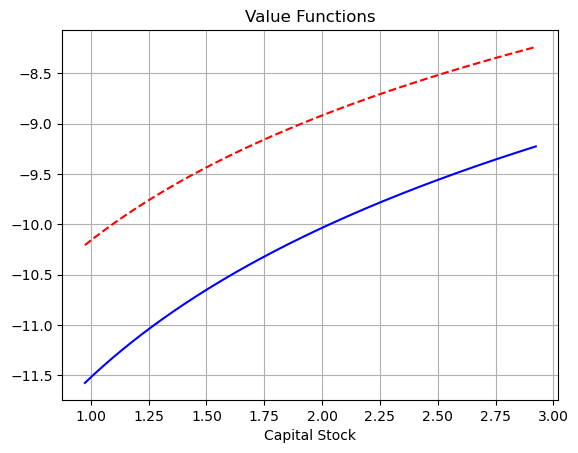

In [13]:
# Make plots of value and policy functions
fig, ax = plt.subplots()
ax.plot(k, V1[:,0], 'b')
ax.plot(k, V1[:,-1], 'r--')

ax.set(xlabel='Capital Stock', title='Value Functions')
ax.grid()

fig.savefig("plot_value.jpg", dpi=800)
plt.show()

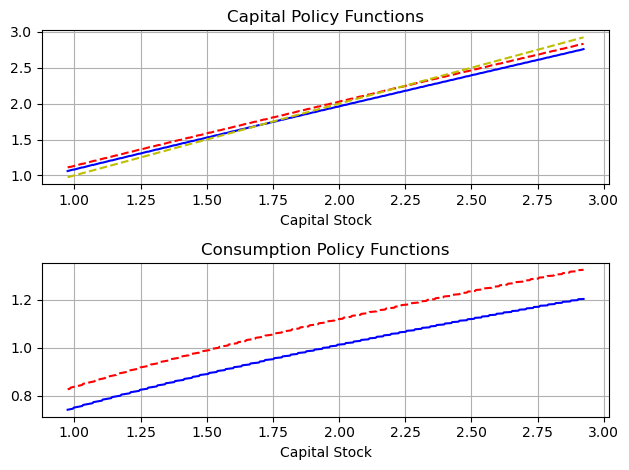

In [14]:
fig2, axs = plt.subplots(2, 1)

axs[0].plot(k, polk[:,0], 'b')
axs[0].plot(k, polk[:,-1], 'r--')
axs[0].plot(k, k, 'y--')
axs[0].set(xlabel='Capital Stock', title='Capital Policy Functions')
axs[0].grid()


axs[1].plot(k, polc[:,0], 'b')
axs[1].plot(k, polc[:,-1], 'r--')
axs[1].set(xlabel='Capital Stock', title='Consumption Policy Functions')
axs[1].grid()


plt.tight_layout()
plt.savefig('plot_policy.jpg', dpi=800)
plt.show()
plt.close(fig2)

In [15]:
# Simulation
if simyes == 1:
    T = int(input('Enter the number of periods for simulation: '))
    S = markov_chain(Pi,T,0,me=1) # Start in state 1
    indk = round(lk/2)-1 # Start with the first capital
    kopt = np.zeros((T+1,))
    shock = np.zeros((T,))
    output = np.zeros((T,))
    invest = np.zeros((T,))
    cons = np.zeros((T,))
    kopt[0] = polk[indk,0]
    #print(S)
    for i in np.arange(0,T):
        indk = optim[indk,S[0,i]]
        shock[i] = teta[S[0,i]]
        kopt[i+1]=k[indk]
        output[i] = A*teta[S[0,i]]*(kopt[i]**alfa)
        invest[i] = kopt[i+1]-(1-delta)*kopt[i]
        cons[i] = output[i]-invest[i]

        
    #serie = np.concatenate((chat, khat))
    #print(serie)
    #print('shock=\n',shock)
    #print('kopt=\n',kopt)
    #print('output=\n',output)
    #print('invest=\n',invest)
    #print('cons=\n',cons)
    
    # The hat-variables are percentage deviation from steady state
    khat  = (kopt - k_ss) / k_ss
    chat  = (cons - c_ss) / c_ss

    
    

Enter the number of periods for simulation: 1000
Transition Matrix:
 [[0.8688 0.1312 0.     0.     0.     0.     0.    ]
 [0.0273 0.8726 0.1001 0.     0.     0.     0.    ]
 [0.     0.0391 0.8861 0.0748 0.     0.     0.    ]
 [0.     0.     0.0547 0.8907 0.0547 0.     0.    ]
 [0.     0.     0.     0.0748 0.8861 0.0391 0.    ]
 [0.     0.     0.     0.     0.1001 0.8726 0.0273]
 [0.     0.     0.     0.     0.     0.1312 0.8688]]


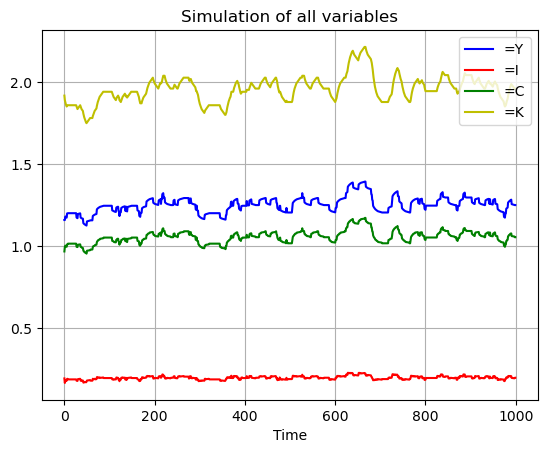

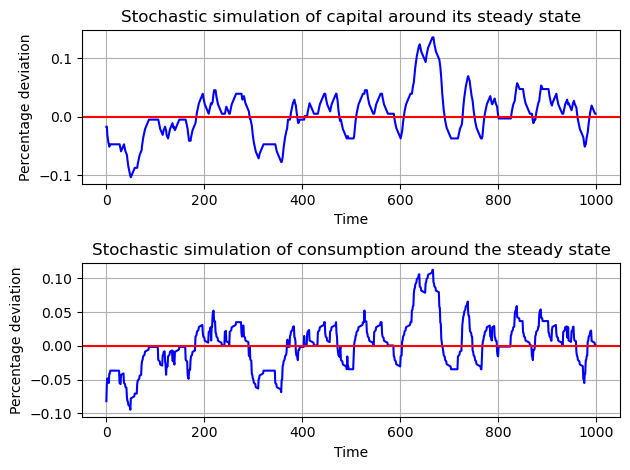

In [16]:
if simyes == 1:
    time = np.arange(0,T)

    
    
    # Make plots of value and policy functions
    fig3, ax3 = plt.subplots()
    ax3.plot(time, output, 'b',label='=Y')
    ax3.plot(time, invest, 'r',label='=I')
    ax3.plot(time, cons, 'g',label='=C')
    ax3.plot(time, kopt[1:T+1], 'y',label='=K')

    ax3.set(xlabel='Time', title='Simulation of all variables')
    ax3.grid()
    ax3.legend()

    fig3.savefig("plot_simul.jpg", dpi=800)
    plt.show()
    
    
    fig4, axs4 = plt.subplots(2, 1)

    axs4[0].plot(time, khat[0:T], 'b')
    axs4[0].axhline(y=0, color='r', linestyle='-')
    axs4[0].set(xlabel='Time', ylabel = 'Percentage deviation', \
                title='Stochastic simulation of capital around its steady state')
    axs4[0].grid()


    axs4[1].plot(time, chat, 'b')
    axs4[1].axhline(y=0, color='r', linestyle='-')
    axs4[1].set(xlabel='Time', ylabel = 'Percentage deviation', \
                title='Stochastic simulation of consumption around the steady state')
    axs4[1].grid()


    plt.tight_layout()
    plt.savefig('plot_policy.jpg', dpi=800)
    plt.show()
    plt.close(fig4)

In [17]:
if simyes == 1:
    X = np.concatenate((output[:,np.newaxis], invest[:,np.newaxis], cons[:,np.newaxis], kopt[0:T][:,np.newaxis]),axis=1)
    #print(X)
    #print(X.shape)
    # Some summary statistics
    print('Correlation of output with investment:')
    print(np.corrcoef(output.T,invest.T))
    print('Correlation of output with consumption:')
    print(np.corrcoef(output.T,cons.T))
    print('Correlation of output with capital:')
    print(np.corrcoef(output.T,kopt[1:T+1].T))
    print('Volatility of output, investment, consumption, and capital')
    vol=np.std(X,axis=0)/np.mean(X,axis=0)
    print(vol)

Correlation of output with investment:
[[1.     0.9427]
 [0.9427 1.    ]]
Correlation of output with consumption:
[[1.     0.9958]
 [0.9958 1.    ]]
Correlation of output with capital:
[[1.     0.9502]
 [0.9502 1.    ]]
Volatility of output, investment, consumption, and capital
[0.0379 0.0532 0.0358 0.0414]
